In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import matplotlib.pyplot as plt


In [2]:
# Load data
df = pd.read_csv("realistic_fraud_dataset.csv")


In [3]:
# Drop IDs and timestamp
df = df.drop(columns=["sender_id", "recipient_id", "device_id", "timestamp"])


In [4]:
# Add features
df['time_since_last_txn'] = df.groupby('is_fraud')['time_of_day'].diff().fillna(0)
df['rolling_std_amount_10'] = (
    df.groupby('is_fraud')['amount']
      .rolling(10, min_periods=1).std()
      .reset_index(level=0, drop=True)
      .fillna(0)
)

In [5]:
# Features & labels
X = df.drop(columns=["is_fraud"])
y = df["is_fraud"]

In [6]:
numeric_features = ["amount", "time_of_day", "day_of_week", "avg_amount_last_10",
                    "txn_count_last_24h", "recipient_diversity", "geo_distance_km",
                    "time_since_last_txn", "rolling_std_amount_10"]

In [7]:
categorical_features = ["transaction_type", "is_known_recipient", "ip_change_flag"]


In [8]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [9]:
# Build full pipeline with preprocessing + SMOTE + model
pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", HistGradientBoostingClassifier(random_state=42))
])

In [10]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Train the full pipeline
pipeline.fit(X_train, y_train)

c:\Users\Dhara\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Dhara\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'time_of_day',
                                                   'day_of_week',
                                                   'avg_amount_last_10',
                                                   'txn_count_last_24h',
                                                   'recipient_diversity',
                                                   'geo_distance_km',
                                                   'time_since_last_txn',
                                                   'rolling_std_amount_10']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['transaction_type',
                                                   'is_known_recipient',
                                                   'ip_change_flag'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 HistGradientBoostingClassifier(random_state=42))])

In [12]:
# Evaluate model
y_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

In [15]:
print(f"\n✅ Classification Report (threshold={threshold}):")
print(classification_report(y_test, y_pred))


✅ Classification Report (threshold=0.3):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    272016
           1       0.89      0.74      0.81     29726

    accuracy                           0.97    301742
   macro avg       0.93      0.87      0.90    301742
weighted avg       0.96      0.97      0.96    301742



In [16]:
print("✅ Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

✅ Confusion Matrix:
[[269159   2857]
 [  7581  22145]]


In [17]:
print("✅ ROC AUC Score:", roc_auc_score(y_test, y_proba))


✅ ROC AUC Score: 0.9324780497069202


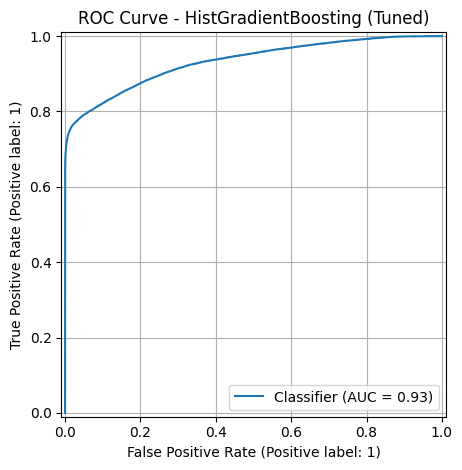

In [18]:
# Plot ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - HistGradientBoosting (Tuned)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
import joblib
joblib.dump(pipeline, "../model/fraud_detection_pipeline.pkl")
print("✅ Pipeline saved successfully.")


✅ Pipeline saved successfully.


In [20]:
import joblib
import pandas as pd

# ✅ Load the trained pipeline
pipeline = joblib.load("../model/fraud_detection_pipeline.pkl")

# ✅ Create a sample input (make sure all features are present)
sample_input_legit= {
    "amount": 150,
    "time_of_day": 10.0,                 # Morning (within user active hours)
    "day_of_week": 2,                    # Wednesday
    "transaction_type": "payment",
    "avg_amount_last_10": 145,
    "txn_count_last_24h": 3,
    "recipient_diversity": 2,
    "is_known_recipient": 1,             # Known recipient
    "geo_distance_km": 5.2,
    "ip_change_flag": 0,                 # Same device/IP
    "time_since_last_txn": 1.5,
    "rolling_std_amount_10": 8.0
}


# ✅ Convert to DataFrame
df_input = pd.DataFrame([sample_input_legit])

# ✅ Predict
prob = pipeline.predict_proba(df_input)[0][1]
label = int(prob >= 0.3)

# ✅ Output
print("Predicted Label (is_fraud):", label)
print("Fraud Probability:", round(prob, 4))


Predicted Label (is_fraud): 0
Fraud Probability: 0.0898


In [22]:
import joblib
import pandas as pd

# ✅ Load the trained pipeline
pipeline = joblib.load("../model/fraud_detection_pipeline.pkl")

# ✅ Create a sample input (make sure all features are present)
sample_input_fraud= {
    "amount": 950,                       # Suspiciously high
    "time_of_day": 3.4,                  # 3:24 AM
    "day_of_week": 6,                    # Sunday (low activity)
    "transaction_type": "transfer",
    "avg_amount_last_10": 130,
    "txn_count_last_24h": 7,
    "recipient_diversity": 10,           # Multiple recipients
    "is_known_recipient": 0,             # New recipient
    "geo_distance_km": 412.7,            # Large jump in location
    "ip_change_flag": 1,                 # New IP/device
    "time_since_last_txn": 0.1,
    "rolling_std_amount_10": 90.5
}

# ✅ Convert to DataFrame
df_input = pd.DataFrame([sample_input_fraud])

# ✅ Predict
prob = pipeline.predict_proba(df_input)[0][1]
label = int(prob >= 0.3)

# ✅ Output
print("Predicted Label (is_fraud):", label)
print("Fraud Probability:", round(prob, 4))


Predicted Label (is_fraud): 1
Fraud Probability: 0.9993


In [ ]:
import joblib
import pandas as pd

# Load model
pipeline = joblib.load("fraud_detection_pipeline.pkl")

# Test case 1: Legitimate
df_legit = pd.DataFrame([sample_input_legit])
label_legit = pipeline.predict(df_legit)[0]
prob_legit = pipeline.predict_proba(df_legit)[0][1]
print("✅ Legitimate Test")
print("Predicted Label:", label_legit)
print("Fraud Probability:", round(prob_legit, 4))

# Test case 2: Fraudulent
df_fraud = pd.DataFrame([sample_input_fraud])
label_fraud = pipeline.predict(df_fraud)[0]
prob_fraud = pipeline.predict_proba(df_fraud)[0][1]
print("\n🚨 Fraudulent Test")
print("Predicted Label:", label_fraud)
print("Fraud Probability:", round(prob_fraud, 4))


✅ Legitimate Test
Predicted Label: 0
Fraud Probability: 0.0898

🚨 Fraudulent Test
Predicted Label: 1
Fraud Probability: 0.9993
